<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pmdarima
!pip install pykalman 
!pip install arch

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pykalman import KalmanFilter
from statsmodels.tsa.ar_model import AR
import seaborn as sns
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr 
from statsmodels.tsa.arima_process import ArmaProcess
from arch import arch_model
import requests
sns.set()

# Constants

In [0]:
H = 6
V = 12

# Monthly Sunspots

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985)

## Data

In [13]:
url='https://raw.githubusercontent.com/jamissonfreitas/IN1167/master/monthly-sunspots.csv'
data = requests.get(url).content
data = data.decode('utf-8').replace("\"","").split('\n')
data = [d.strip().split(',') for d in data][1:-1]
data[:5]

[['1749-01', '58.0'],
 ['1749-02', '62.6'],
 ['1749-03', '70.0'],
 ['1749-04', '55.7'],
 ['1749-05', '85.0']]

In [14]:
df = pd.DataFrame(
    data, 
    columns=['Month', 'Sunspots']
) 
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m', errors='coerce')
df = df.set_index(df['Month'])
serie = df['Sunspots']
serie[:10]

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
1749-06-01    83.5
1749-07-01    94.8
1749-08-01    66.3
1749-09-01    75.9
1749-10-01    75.5
Name: Sunspots, dtype: object

## Plot Serie

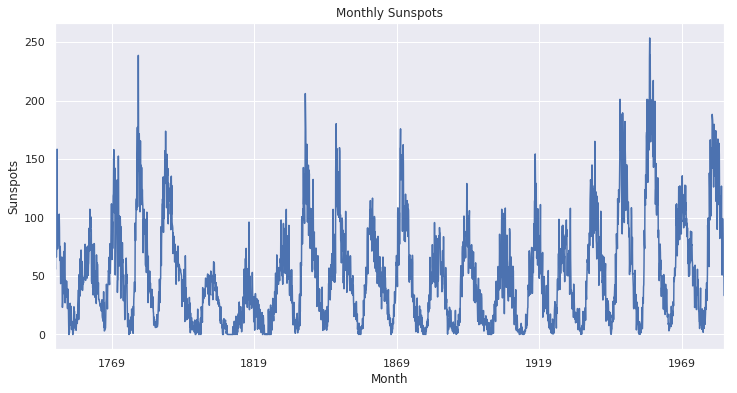

In [15]:
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.title('Monthly Sunspots')
plt.ylabel('Sunspots')
plt.xlabel('Month')
plt.show()

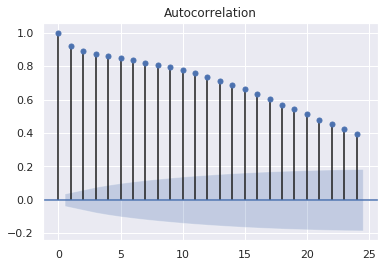

In [18]:
plot_acf(serie, lags=24)
plt.show()

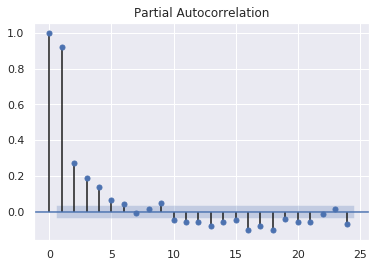

In [19]:
plot_pacf(serie, lags=24)
plt.show()

### Plot Diff

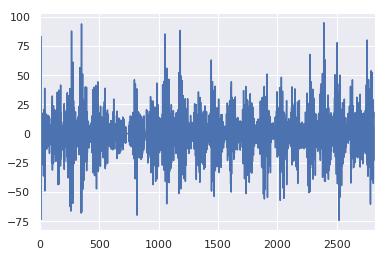

In [16]:
s_diff = np.diff(serie)
s_diff = pd.Series(s_diff)
s_diff.plot()

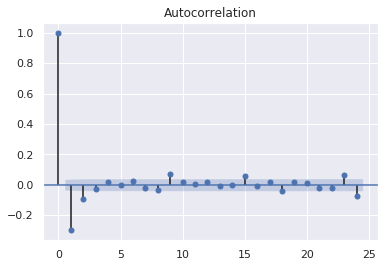

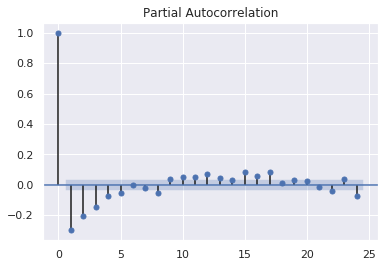

In [21]:
plot_acf(s_diff, lags=24)

plot_pacf(s_diff, lags=24)

plt.show()

## Seasonal decompose

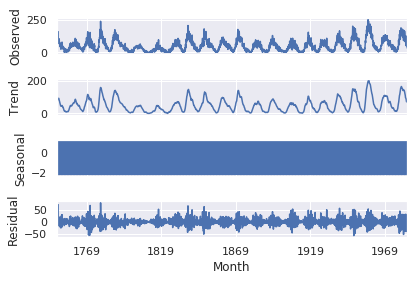

In [24]:
decompose = seasonal_decompose(serie, model='additive')
decompose.plot()
plt.show()

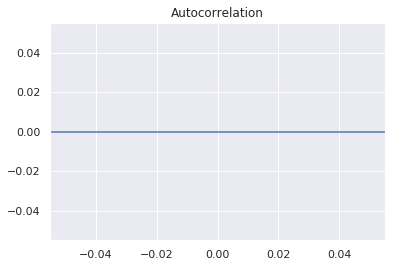

In [26]:
plot_acf(decompose.resid, lags=36)
plt.show()

## Data train and test

In [28]:
size = len(serie)
l = int((7*size)/10)
print(size, l)

# original serie
serie_train = serie[:l]
serie_test = serie[l:]

size = len(s_diff)
l = int((7*size)/10)
print(size, l)

# diff serie
s_diff_train = s_diff[:l]
s_diff_test = s_diff[l:]

2820 1974
2819 1973


## Models

### Holt-Winters

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


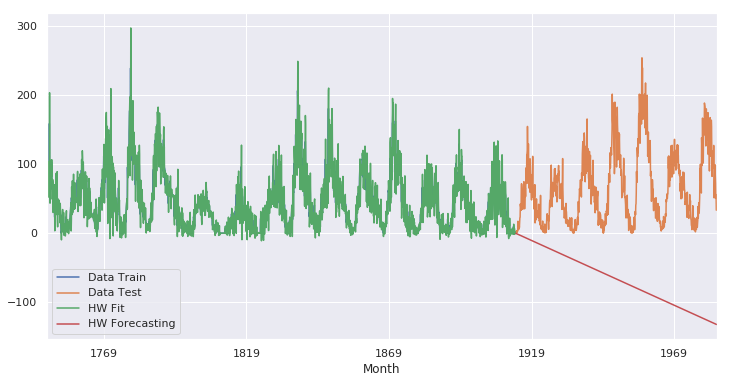

In [34]:
plt.figure(figsize=(V,H))

# fit the data
hw = Holt(serie_train).fit(smoothing_level=0.8, smoothing_slope=0.9)

# original serie
serie_train.plot(label='Data Train')

# original serie
serie_test.plot(label='Data Test')

# plot the data
hw.fittedvalues.plot(label='HW Fit')

# predict
predict = hw.predict(start=serie_test.index[0], end=serie_test.index[-1])
predict.plot(label='HW Forecasting')

# to show the plot
# hw.forecast(25).rename('HW Forecasting').plot()
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error
print('MSE Train = ', mean_squared_error(serie_train, hw.fittedvalues))
print('MSE Test = ', mean_squared_error(serie_test, predict))

MSE Train =  473.3676701919243
MSE Test =  22608.15671122743


### AR

In [49]:
# train AR
model = AR(serie_train)
model_fitted = model.fit(maxlag=5)

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  5
parameters:  const          1.844983
L1.Sunspots    0.546881
L2.Sunspots    0.145316
L3.Sunspots    0.073653
L4.Sunspots    0.098486
L5.Sunspots    0.093112
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


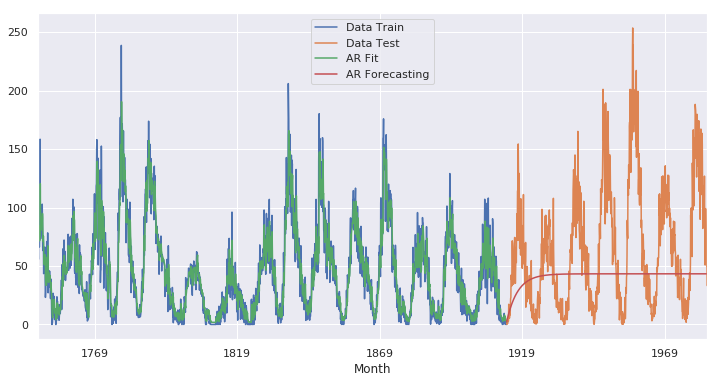

In [52]:
plt.figure(figsize=(V,H))

# plot data train and test
serie_train.plot(label='Data Train')

serie_test.plot(label='Data Test')

predict_train = model_fitted.predict(start=model_fitted.k_ar, end=len(serie_train), dynamic=False)
predict_train.plot(label='AR Fit')

predict = model_fitted.predict(start=serie_test.index[0], end=serie_test.index[-1], dynamic=False)
predict.plot(label='AR Forecasting')

#to show
plt.legend()
plt.show()

In [54]:
# print("MSE AR Train= ", mean_squared_error(serie_train, model_fitted.fittedvalues))
print("MSE AR Test = ", mean_squared_error(serie_test, predict))

MSE AR Test =  3178.028418800858


### ARMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


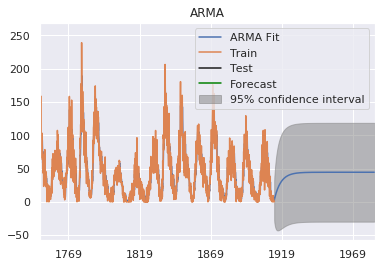

In [60]:
# ARMA(p,q) = ARIMA(p,0,q)
model_arma = ARIMA(serie_train, order=(5, 0, 2))  
fitted_arma = model_arma.fit(disp=0)  
# Forecast
fc_arma, se_arma, conf_arma = fitted_arma.forecast(len(serie_test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_arma = pd.Series(fc_arma, index=serie_test.index)
arma_fittedValues = fitted_arma.fittedvalues

# Plot
fitted_arma.plot_predict(dynamic=False, end=len(serie_train) + len(serie_test))
plt.plot(serie_test, label="Test", color="k")
plt.plot(fc_series_arma, label='Forecast',color="green")
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
plt.title("ARMA")
L=plt.legend(loc='best')
L.get_texts()[0].set_text('ARMA Fit')
L.get_texts()[1].set_text('Train')
plt.show()

In [59]:
# MSE
mse_ar_train = mean_squared_error(serie_train, ar_fittedValues)
mse_ar = mean_squared_error(serie_test, fc_series_ar)

print("MSE AR Train= ", mse_ar_train)
print("MSE AR Test = ", mse_ar)

MSE AR Train=  262.6083068790627
MSE AR Test =  3052.0877483492654


### ARIMA

In [62]:
# train ARIMA
model = ARIMA(serie_train, order=(5, 1, 2))
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


lags used:  5
parameters:  const              -0.032087
ar.L1.D.Sunspots   -0.905078
ar.L2.D.Sunspots   -0.044265
ar.L3.D.Sunspots   -0.164319
ar.L4.D.Sunspots   -0.110550
ar.L5.D.Sunspots   -0.022192
ma.L1.D.Sunspots    0.454496
ma.L2.D.Sunspots   -0.467330
dtype: float64


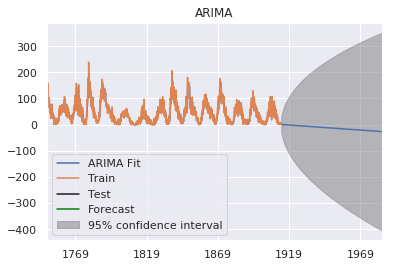

In [64]:
# Forecast
fc, se, conf = model_fitted.forecast(len(serie_test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=serie_test.index)
arima_fittedValues = model_fitted.fittedvalues

# Plot
model_fitted.plot_predict(dynamic=False, start=1, end=len(serie_train)+len(serie_test))
plt.plot(serie_test, label="Test", color="k")
plt.plot(fc_series, label='Forecast',color="green")
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
plt.title("ARIMA")
L=plt.legend(loc='best')
L.get_texts()[0].set_text('ARIMA Fit')
L.get_texts()[1].set_text('Train')
plt.show()


In [68]:
# MSE
print("MSE ARIMA Train (on returns)= ", mean_squared_error(serie_train[1:], arima_fittedValues))
print("MSE ARIMA Test= ", mean_squared_error(serie_test, fc_series))

MSE ARIMA Train (on returns)=  3599.055166430252
MSE ARIMA Test=  9136.799907117958


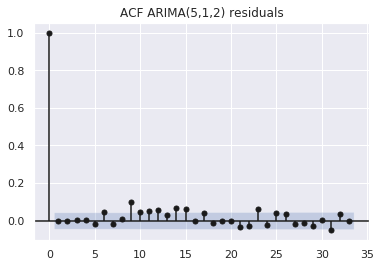

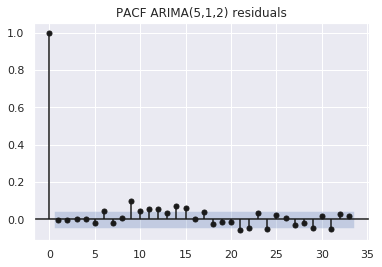

In [70]:
#plot residual errors
residuals = pd.DataFrame(model_fitted.resid)
# plt.plot(residuals)
# plt.show()
plot_acf(residuals,color="k")
plt.title("ACF ARIMA(5,1,2) residuals")
plt.show()
plot_pacf(residuals,color="k")
plt.title("PACF ARIMA(5,1,2) residuals")
plt.show()

### GARCH

In [75]:
from arch import arch_model

am = arch_model(serie_train, mean='Zero', vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 9986.461642473816
Iteration:      2,   Func. Count:     11,   Neg. LLF: 9960.956930521961
Iteration:      3,   Func. Count:     16,   Neg. LLF: 9835.03995843447
Iteration:      4,   Func. Count:     21,   Neg. LLF: 9776.148996365999
Iteration:      5,   Func. Count:     26,   Neg. LLF: 9764.983901122489
Iteration:      6,   Func. Count:     32,   Neg. LLF: 9762.1347813934
Iteration:      7,   Func. Count:     38,   Neg. LLF: 9759.70870480983
Iteration:      8,   Func. Count:     44,   Neg. LLF: 9757.652788571093
Iteration:      9,   Func. Count:     50,   Neg. LLF: 9755.92941340146
Iteration:     10,   Func. Count:     56,   Neg. LLF: 9754.563470658413
Iteration:     11,   Func. Count:     62,   Neg. LLF: 9752.633287431974
Iteration:     12,   Func. Count:     67,   Neg. LLF: 9752.268676493099
Iteration:     13,   Func. Count:     72,   Neg. LLF: 9750.907859446987
Iteration:     14,   Func. Count:     77,   Neg. LLF: 9750.5057565618

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1436. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


In [76]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 5
o_ = 1
q_ = 2

# Using student T distribution usually provides better fit
am = arch_model(s_diff, mean='Zero', vol='GARCH', p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -11469.3
Distribution:      Standardized Student's t   AIC:                           22958.5
Method:                  Maximum Likelihood   BIC:                           23018.0
                                              No. Observations:                 2819
Date:                      Wed, Oct 09 2019   Df Residuals:                     2809
Time:                              00:47:14   Df Model:                           10
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


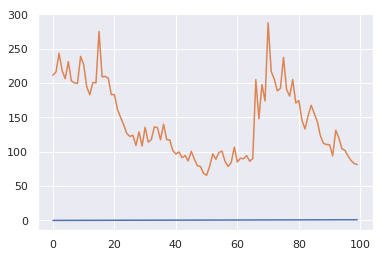

In [74]:
n_test = 100

# forecast the test set
yhat = am.forecast(horizon=n_test, method='simulation', simulations=5, params=res.params)

# plot the actual variance
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-n_test:])

# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

<bound method ARCHModelResult.summary of                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7985.78
Distribution:                  Normal   AIC:                           15991.6
Method:            Maximum Likelihood   BIC:                           16047.4
                                        No. Observations:                 1973
Date:                Wed, Oct 09 2019   Df Residuals:                     1963
Time:                        00:50:35   Df Model:                           10
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5922      0.

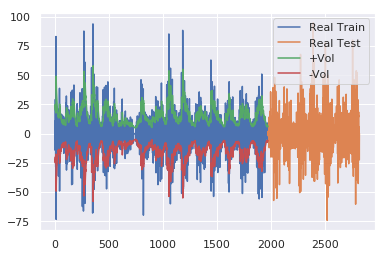

In [78]:
# training a Garch model
garch = arch_model(s_diff_train, vol='GARCH', p=p_, o=o_, q=q_ ).fit( disp='off')

# printing the statisticals
print(garch.summary)

# plotting the modelling
plt.plot(s_diff_train, label='Real Train')
plt.plot(s_diff_test, label='Real Test')
plt.plot(garch._volatility, label = '+Vol')
plt.plot(-garch._volatility, label = '-Vol')
plt.legend(loc='best')
plt.show()

### KALMAN

In [0]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 3.713572,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=0.85)

# Use the observed values
state_means, _ = kf.filter(serie_train)
state_means = pd.Series(state_means.flatten(), index=serie_train.index)

# Compute the rolling mean with various lookback windows
mean5 = pd.Series(serie_train).rolling(window=5).mean()
mean10 = pd.Series(serie_train).rolling(window=10).mean()

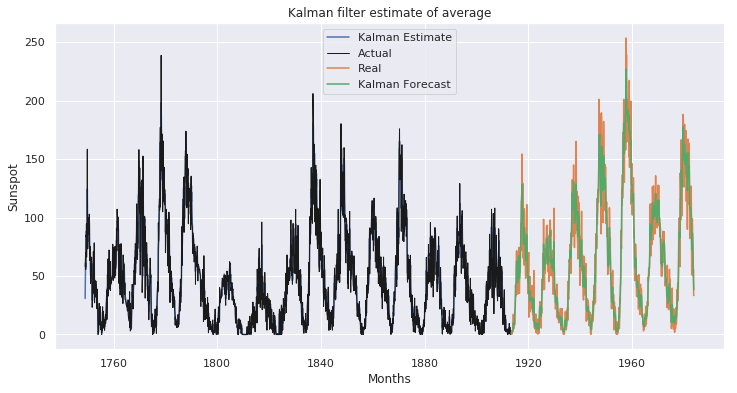

In [120]:
plt.figure(figsize=(V,H))

kalman_forecast = pd.Series([i[0] for i in kf.smooth(serie_test)[0]], index=serie_test.index)

# Plot original data and estimated mean
plt.plot(state_means, label="Kalman Estimate")
plt.plot(serie_train, label="Actual",color="k", linewidth=1)
#plt.plot(mean5, label="5W moving average")
#plt.plot(mean10, label="10W moving average")
plt.plot(serie_test, label="Real")
plt.plot(kalman_forecast, label="Kalman Forecast")
plt.title('Kalman filter estimate of average')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Sunspot')
plt.show()

In [121]:
mse_kalman = mean_squared_error(serie_train, state_means)
print("MSE KALMAN = ", mse_kalman)
print("MSE KALMAN Test = ", mean_squared_error(serie_test, kalman_forecast))

MSE KALMAN =  39.55553811547743
MSE KALMAN Test =  82.24773403633758
